
# Autoencoders

# Vanilla Autoencoder

## Data preparing


In [ ]:
import numpy as np
import pandas as pd
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from skimage import io, transform
import os
%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: transform.resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

In [ ]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
X_train, X_val, X_train_attrs, X_val_attrs = train_test_split(data, attrs, test_size=0.2)

Show some images



In [ ]:
def show_example_images(amount_images, images):
  #print(images.shape)
    random_image = [np.random.randint(0, len(images)-1) for pic in range(amount_images)]
    if amount_images % 4 == 0:
        rows = int(amount_images / 4)
    else: 
        rows = int(amount_images/4 + 1)
    fig = plt.figure()
  
    for idx, im in enumerate(random_image):
        fig.add_subplot(rows, 4, idx+1)
        plt.imshow(images[im])
        plt.axis('off')

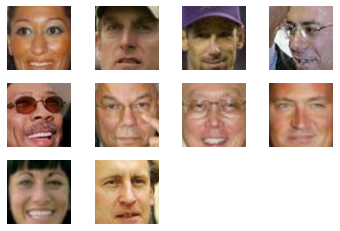

In [ ]:
show_example_images(10, X_train)

In [ ]:
import torch
import torch.nn as nn

In [ ]:
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)

In [ ]:
X_train.shape

(10514, 64, 64, 3)

In [ ]:
batch_size=32
data_loader_train = torch.utils.data.DataLoader(list(zip(np.rollaxis(X_train,3,1), np.rollaxis(X_train,3,1))), batch_size=batch_size) 
data_loader_val = torch.utils.data.DataLoader(list(zip(np.rollaxis(X_val,3,1), np.rollaxis(X_val,3,1))), batch_size=batch_size)       

## Build and train Model




<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


In [ ]:
dim_code = 32 # выберите размер латентного вектора

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),  #64*64*3 --> 64*64*16
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2), #64*64*16 --> 32*32*16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), #32*32*16 --> 32*32*32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2), #32*32*32 --> 16*16*32
            nn.Flatten(),
            nn.Linear(in_features=16*16*32, out_features=dim_code)     #in: 16*16*32 --> 32
            )


        self.decoder = nn.Sequential(
            nn.Linear(in_features=32, out_features=16*16*32),
            nn.Unflatten(1, (32,16,16)),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1), #16*16*32 --> 16*16*16 
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'), #16*16*16 --> up 32*32*16
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=1), #32*32*16 --> 32*32*3 
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear') #32*32*3 --> up 64*64*3
        )
        
        
    def forward(self, x):       
        #encoder                  
        latent_code = self.encoder(x)
        #print(f'latent code: {latent_code.shape}')
        #decoder
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code
    
    def sample(self, new_lat_code):
        generation = self.decoder(new_lat_code)
        return generation
        

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
autoencoder

In [ ]:
!pip install torch-summary
from torchsummary import summary

In [ ]:
summary(autoencoder, (3,64,64))

latent code: torch.Size([2, 32])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32]                  --
|    └─Conv2d: 2-1                       [-1, 16, 64, 64]          448
|    └─ReLU: 2-2                         [-1, 16, 64, 64]          --
|    └─BatchNorm2d: 2-3                  [-1, 16, 64, 64]          32
|    └─MaxPool2d: 2-4                    [-1, 16, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 32, 32, 32]          4,640
|    └─ReLU: 2-6                         [-1, 32, 32, 32]          --
|    └─BatchNorm2d: 2-7                  [-1, 32, 32, 32]          64
|    └─MaxPool2d: 2-8                    [-1, 32, 16, 16]          --
|    └─Flatten: 2-9                      [-1, 8192]                --
|    └─Linear: 2-10                      [-1, 32]                  262,176
├─Sequential: 1-2                        [-1, 3, 64, 64]           --
|    └─Linear: 2-11                      [-

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32]                  --
|    └─Conv2d: 2-1                       [-1, 16, 64, 64]          448
|    └─ReLU: 2-2                         [-1, 16, 64, 64]          --
|    └─BatchNorm2d: 2-3                  [-1, 16, 64, 64]          32
|    └─MaxPool2d: 2-4                    [-1, 16, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 32, 32, 32]          4,640
|    └─ReLU: 2-6                         [-1, 32, 32, 32]          --
|    └─BatchNorm2d: 2-7                  [-1, 32, 32, 32]          64
|    └─MaxPool2d: 2-8                    [-1, 32, 16, 16]          --
|    └─Flatten: 2-9                      [-1, 8192]                --
|    └─Linear: 2-10                      [-1, 32]                  262,176
├─Sequential: 1-2                        [-1, 3, 64, 64]           --
|    └─Linear: 2-11                      [-1, 8192]                270,336
|

In [ ]:
from IPython.display import clear_output

In [ ]:
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore')

## Train

In [ ]:
def train(AE_model, loss, optim, data_train, data_val, epochs=10):
    history = {
      'loss': {
          'train': [],
          'val': []
          }
      }    
    for epoch in range(epochs):
      #clear_output(wait=True)
        print(f'{epoch+1} of {epochs}')
        train_loss = []
        avg_loss = 0
        AE_model.train()
        for X_batch_in, X_batch_out in data_train:       
            X_batch_in = X_batch_in.to(device)
            X_batch_out = X_batch_out.to(device)
            optim.zero_grad()
            X_pred, _ = AE_model(X_batch_in)
            _loss = loss(X_pred, X_batch_out)
            _loss.backward()
            optim.step()
            train_loss.append(_loss.mean().item())
        history['loss']['train'].append(sum(train_loss) / len(train_loss))

        AE_model.eval()
        val_loss = []
        pic_examples = []
        with torch.no_grad():           
            for X_batch_val_in, X_batch_val_out in data_val:
                proba_img = np.round(np.random.randint(0, 6)/10 + 10e-8)
                X_batch_val_in = X_batch_val_in.to(device)
                X_batch_val_out = X_batch_val_out.to(device)
                X_val_pred, lc = AE_model(X_batch_val_in)
                _loss = loss(X_val_pred, X_batch_val_out)
                val_loss.append(_loss.mean().item())
                if proba_img:
                    k = np.random.randint(0, len(X_batch_val_in))
                    pic_examples.append((X_val_pred[k].cpu().numpy(), X_batch_val_out[k].cpu().numpy()))
        
            print(f'{epoch+1} / {epochs} - loss: {sum(train_loss) / len(train_loss)}')
            history['loss']['val'].append(sum(val_loss) / len(val_loss))     
      
            for i in range(1,3): #можно выводить все изображения pic_examples, для демонстрации вывод 2х изображений
                plt.subplot(2, 2, 1)
                plt.imshow(np.rollaxis(pic_examples[i][0], 0, 3))
                plt.title('Predict')
                plt.axis('off')

                plt.subplot(2, 2, 2)
                plt.imshow(np.rollaxis(pic_examples[i][1], 0, 3))
                plt.title('Input')
                plt.axis('off')
                plt.show()  
            plt.plot(history['loss']['train'])
            plt.plot(history['loss']['val'])
            plt.show()
             
    return history

1 of 15
1 / 15 - loss: 0.01699801088568378


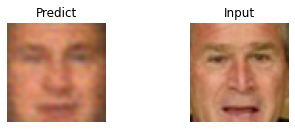

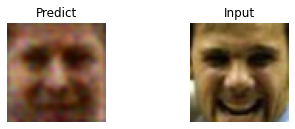

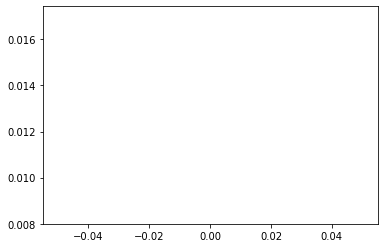

2 of 15
2 / 15 - loss: 0.008257285366259448


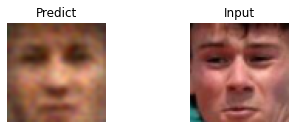

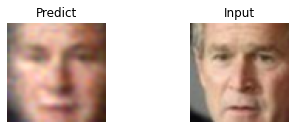

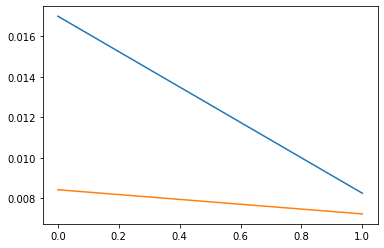

3 of 15
3 / 15 - loss: 0.007346280093239705


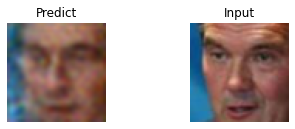

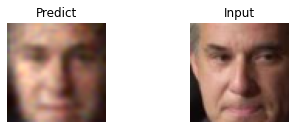

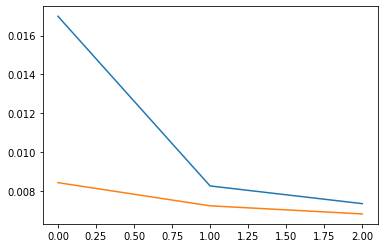

4 of 15
4 / 15 - loss: 0.006975217899279301


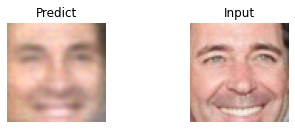

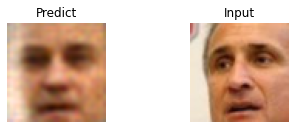

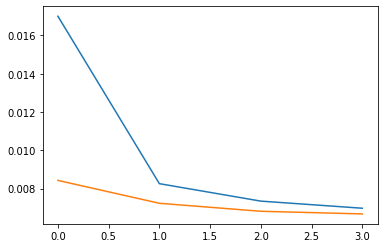

5 of 15
5 / 15 - loss: 0.00672608483327966


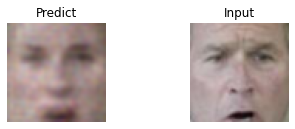

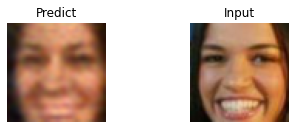

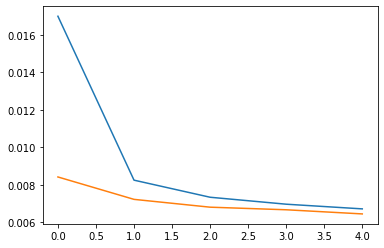

6 of 15
6 / 15 - loss: 0.006538736182448984


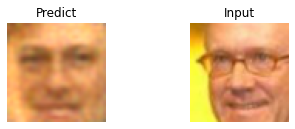

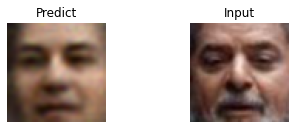

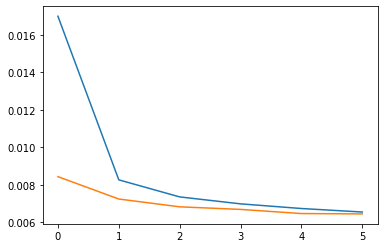

7 of 15
7 / 15 - loss: 0.006394620541777564


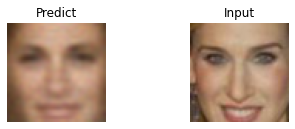

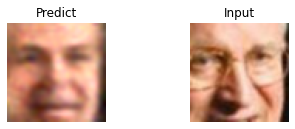

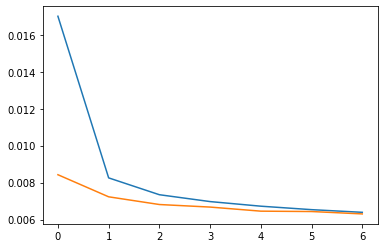

8 of 15
8 / 15 - loss: 0.0062950479735742046


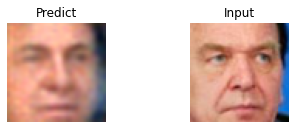

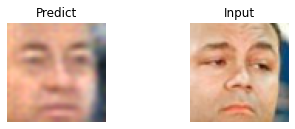

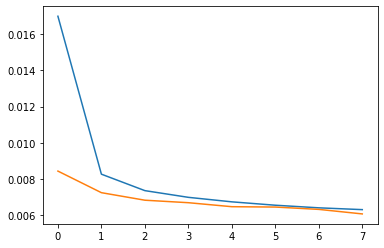

9 of 15
9 / 15 - loss: 0.006250423028227225


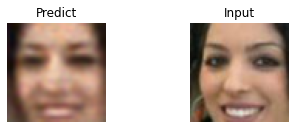

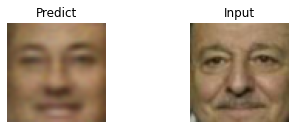

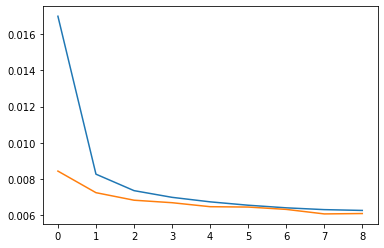

10 of 15
10 / 15 - loss: 0.006226276255589217


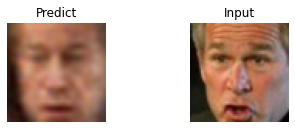

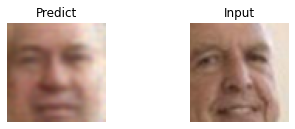

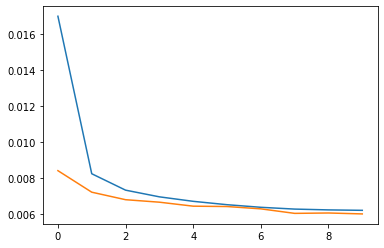

11 of 15
11 / 15 - loss: 0.0062501464310841


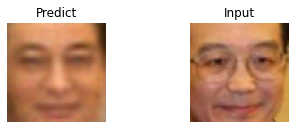

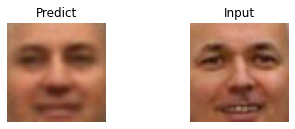

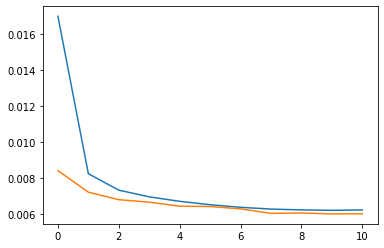

12 of 15
12 / 15 - loss: 0.006311584816039695


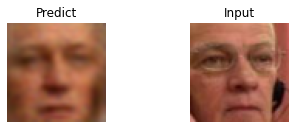

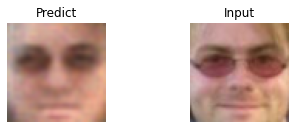

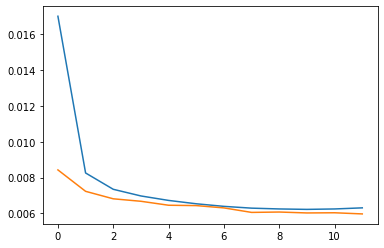

13 of 15
13 / 15 - loss: 0.006404670674387807


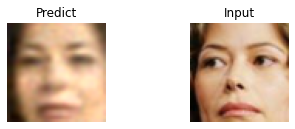

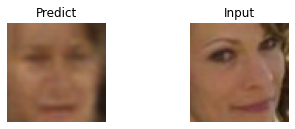

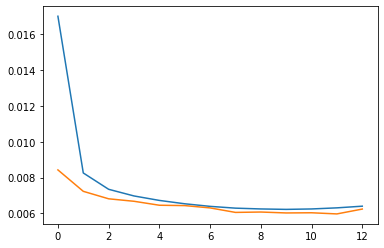

14 of 15
14 / 15 - loss: 0.006326887038986462


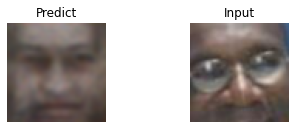

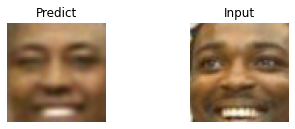

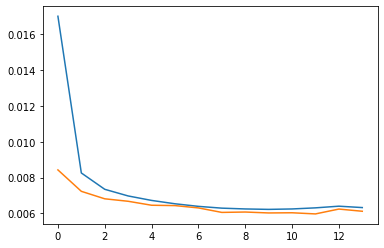

15 of 15
15 / 15 - loss: 0.006181995166426009


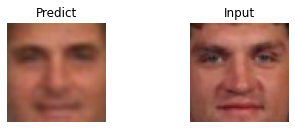

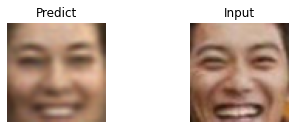

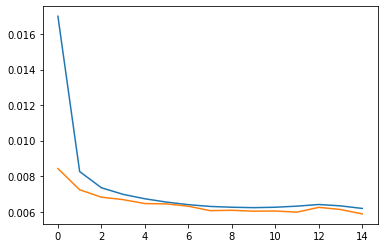

In [ ]:
history_AE = train(autoencoder, criterion, optimizer, data_loader_train, data_loader_val, 15)

In [ ]:
history_AE #show metrics

{'loss': {'train': [0.01699801088568378,
   0.008257285366259448,
   0.007346280093239705,
   0.006975217899279301,
   0.00672608483327966,
   0.006538736182448984,
   0.006394620541777564,
   0.0062950479735742046,
   0.006250423028227225,
   0.006226276255589217,
   0.0062501464310841,
   0.006311584816039695,
   0.006404670674387807,
   0.006326887038986462,
   0.006181995166426009],
  'val': [0.008427771627454155,
   0.007233312493751207,
   0.0068163791256227405,
   0.006678277587361005,
   0.006457224263843283,
   0.006437473257173257,
   0.006308258572840188,
   0.006057651461023523,
   0.006078613259975451,
   0.006027341141444014,
   0.006037405995001276,
   0.0059734514117779506,
   0.006244146837347962,
   0.006121759314134896,
   0.0058742777769824105]}}

Try to encode and decode some images

In [ ]:
def show_images(amount_img, model, images):
    batch = torch.tensor(np.rollaxis(images[0:amount_img], 3, 1))
    model.eval()
    pred = model(batch.to(device))
    with torch.no_grad():
        for i in range(0, len(batch)): 
            plt.subplot(2, 2, 1)
            plt.imshow(np.rollaxis(pred[0][i].cpu().numpy(), 0, 3))
            plt.title('Predict')
            plt.axis('off')

            plt.subplot(2, 2, 2)
            plt.imshow(np.rollaxis(batch[i].cpu().numpy(), 0, 3))
            plt.title('Input')
            plt.axis('off')
            plt.show() 
    return pred[1]

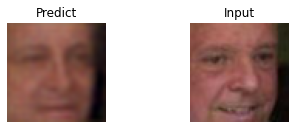

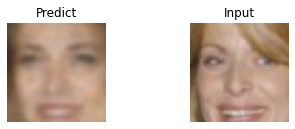

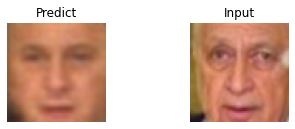

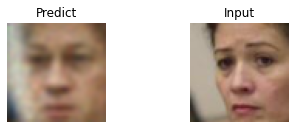

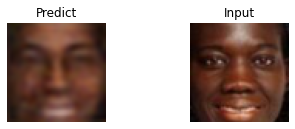

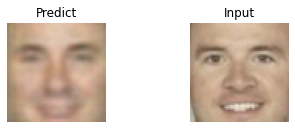

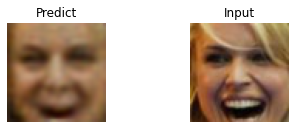

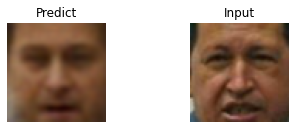

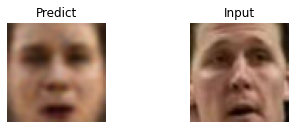

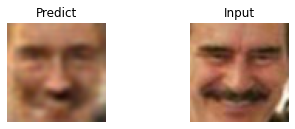

In [ ]:
lc_dataset = show_images(10, autoencoder, X_val)

Not bad

## 1.4. Sampling

In [ ]:
z = np.random.randn(25, dim_code)
output = autoencoder.sample(torch.Tensor(z).to(device))

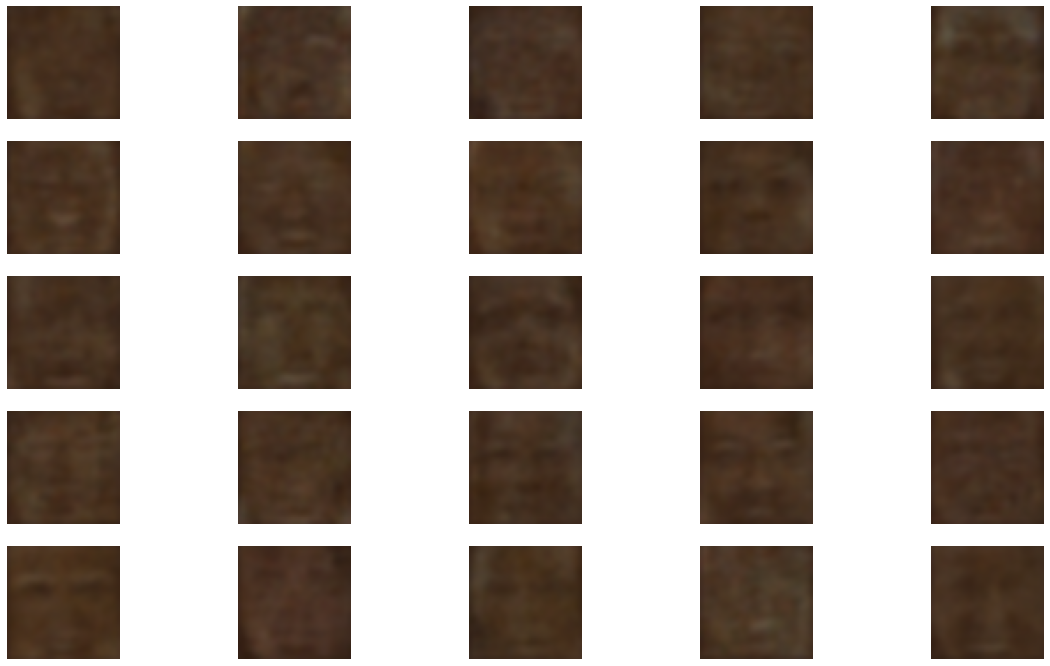

In [ ]:
#try to generate some new images
output = output.detach()
fig = plt.figure(figsize=(20,12))
for idx in range(len(output)):
    fig.add_subplot(5, 5, idx+1)
    pic = np.rollaxis(output[idx].cpu().numpy(), 0, 3)
    plt.imshow(pic)
    #print(pic.shape)
    plt.axis('off')

Bad result. Next I try to find max and min from dataset vector

In [ ]:
lc_dataset = lc_dataset.detach().cpu().numpy()

In [ ]:
lc_min_ds = lc_dataset.min()
lc_max_ds = lc_dataset.max()

In [ ]:
z = np.random.uniform(lc_min_ds, lc_max_ds, size=(25, dim_code))
output = autoencoder.sample(torch.Tensor(z).to(device))

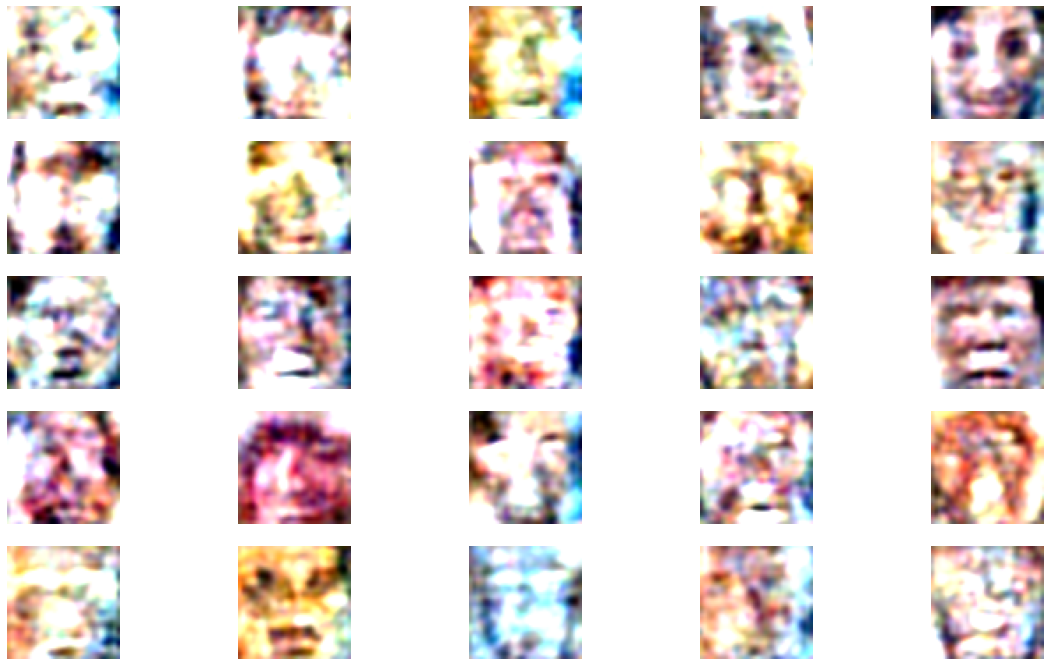

In [ ]:
output = output.detach()
fig = plt.figure(figsize=(20,12))
for idx in range(len(output)):
    fig.add_subplot(5, 5, idx+1)
    pic = np.rollaxis(output[idx].cpu().numpy(), 0, 3)
    plt.imshow(pic)
    #print(pic.shape)
    plt.axis('off')

Bad result again. Try to generate random by columns latent_code

In [ ]:
def generate_latent_code(data):
    lc_min_ds_ax = data.min(axis=0)
    lc_max_ds_ax = data.max(axis=0)
    inp = []
    for min_lc, max_lc in zip(lc_min_ds_ax, lc_max_ds_ax):
        inp.append(np.random.uniform(min_lc, max_lc))
    return inp

In [ ]:
size = 25
z = []
for _ in range(size):
    z.append(generate_latent_code(lc_dataset))
z = np.array(z)

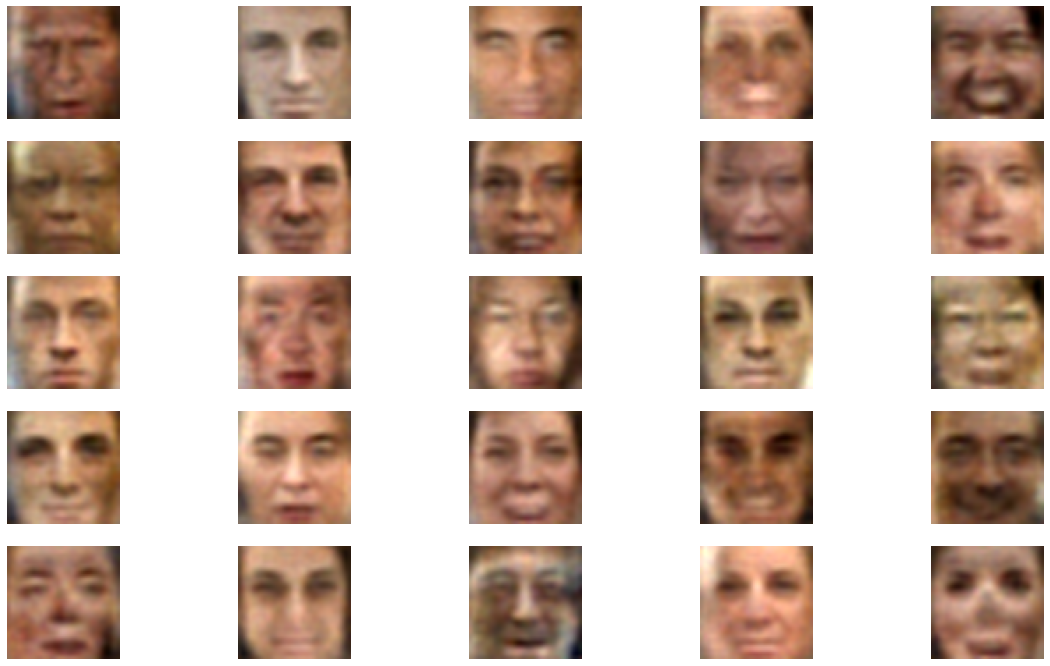

In [ ]:
output = autoencoder.sample(torch.Tensor(z).to(device))
output = output.detach()
fig = plt.figure(figsize=(20,12))
for idx in range(len(output)):
    fig.add_subplot(5, 5, idx+1)
    pic = np.rollaxis(output[idx].cpu().numpy(), 0, 3)
    plt.imshow(pic)
    #print(pic.shape)
    plt.axis('off')

Good result. New faces.

## Try to draw smiles

In [ ]:
attrs_headers = attrs.columns.values.tolist()

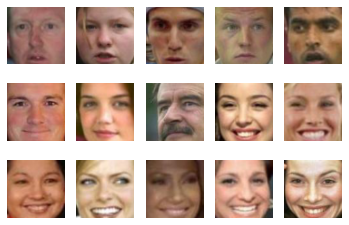

In [ ]:
#i_smile_min = attrs.loc[attrs['Smiling'] == attrs['Smiling'].min()].index.to_numpy()
#i_smile_max = attrs.loc[attrs['Smiling'] == attrs['Smiling'].max()].index.to_numpy()
i_smile = attrs.loc[attrs['Smiling'] >= 2.7].index.to_numpy()
i_not_smile = attrs.loc[attrs['Smiling'] <= -2.6].index.to_numpy()
i_neutral = attrs.loc[(attrs['Smiling'] <= 0.001) & (attrs['Smiling'] > 0.0)].index.to_numpy()
i_pics = np.concatenate((i_not_smile, i_neutral, i_smile))
fig, ax = plt.subplots(3,round(len(i_pics)/3))
ax = ax.flatten()
for a, i in zip(ax, range(len(i_pics))):
    a.imshow(data[i_pics[i]])
    a.axis('off')


Choose indexes smiling and unsmiling people

In [ ]:
i_smiled_people = attrs.loc[attrs['Smiling'] >= 2.6].index.to_numpy()
i_not_smiled_people = attrs.loc[attrs['Smiling'] <= -2.47].index.to_numpy()
smile_people_data = data[i_smiled_people].astype(np.float32)
not_smile_people_data = data[i_not_smiled_people].astype(np.float32)

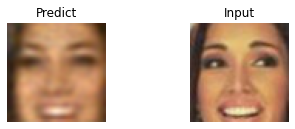

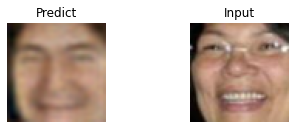

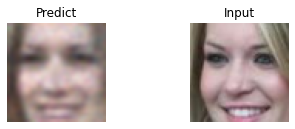

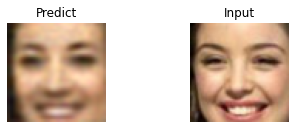

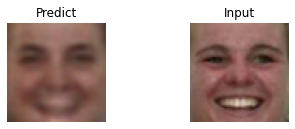

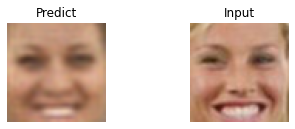

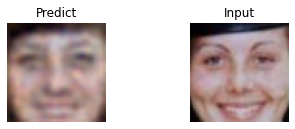

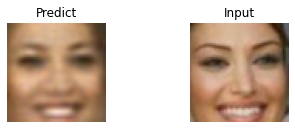

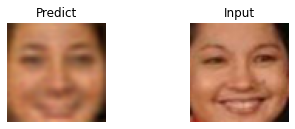

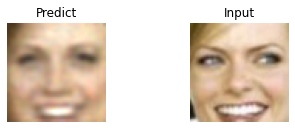

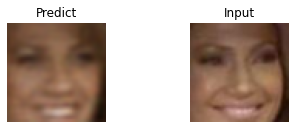

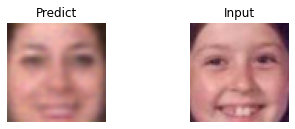

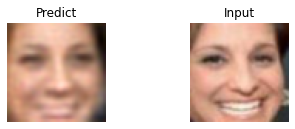

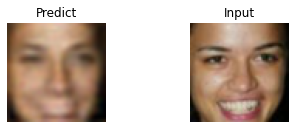

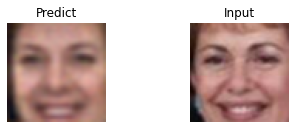

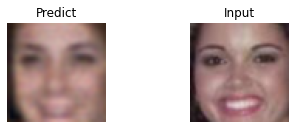

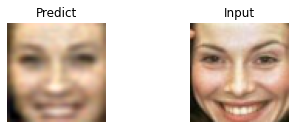

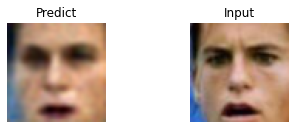

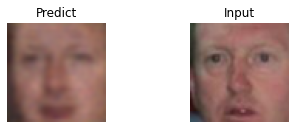

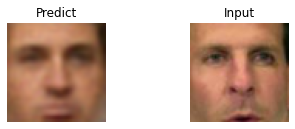

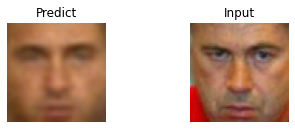

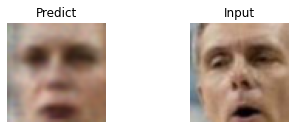

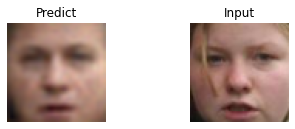

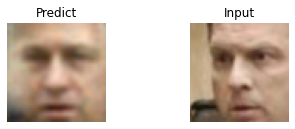

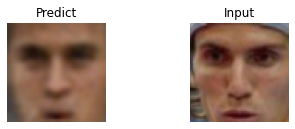

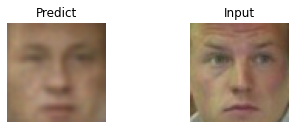

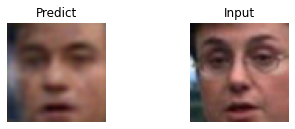

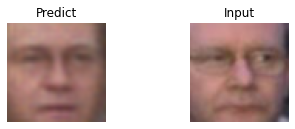

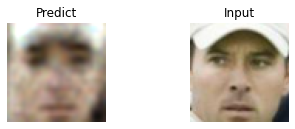

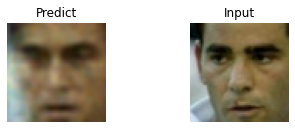

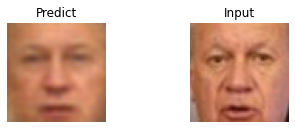

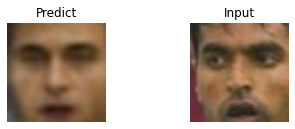

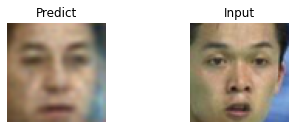

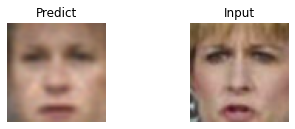

In [ ]:
lc_data_smile = show_images(len(smile_people_data), autoencoder, smile_people_data)
lc_data_not_smile = show_images(len(not_smile_people_data), autoencoder, not_smile_people_data)

Calsulate subtraction vector and add to 'not smile' vector

In [ ]:
lc_difference_smile = lc_data_smile - lc_data_not_smile
lc_difference_smile.shape

torch.Size([17, 32])

In [ ]:
lc_data_reconstruct_smile = lc_data_not_smile + lc_difference_smile

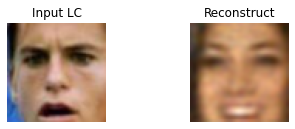

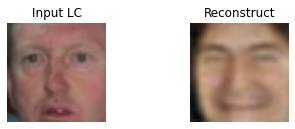

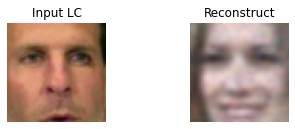

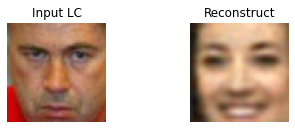

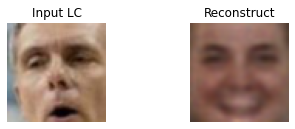

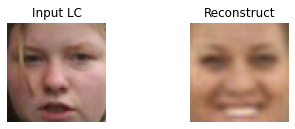

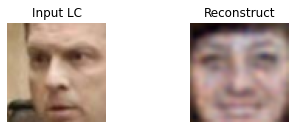

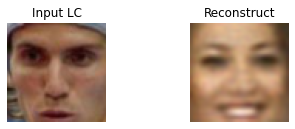

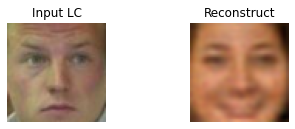

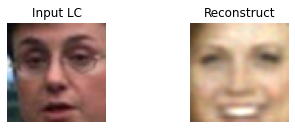

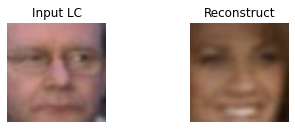

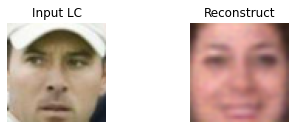

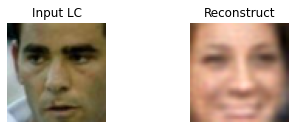

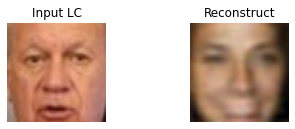

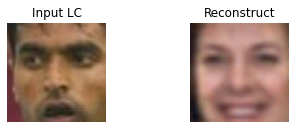

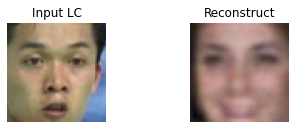

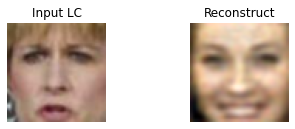

In [ ]:
output_result = autoencoder.sample(lc_data_reconstruct_smile.to(device))
output_result = output_result.detach()
for i in range(0, len(output_result)): 
            plt.subplot(2, 2, 1)
            plt.imshow(not_smile_people_data[i])
            plt.title('Input LC')
            plt.axis('off')

            plt.subplot(2, 2, 2)
            plt.imshow(np.rollaxis(output_result[i].cpu().numpy(), 0, 3))
            plt.title('Reconstruct')
            plt.axis('off')
            plt.show() 

# Variational Autoencoder

In [ ]:
from torchvision import transforms

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset.data[:,None,:,:], batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset.data[:,None,:,:], batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Build and train model

In [ ]:
dim = 16

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),  #28*28*1 --> 28*28*8
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2), #28*28*8 --> 14*14*8
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1), #14*14*8 --> 14*14*16
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2), #14*14*16 --> 7*7*16
            nn.Flatten(),
            nn.Linear(in_features=7*7*16, out_features=dim*2)     #in: 7*7*16 --> 16*2
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=16, out_features=7*7*16),
            nn.Unflatten(1, (16,7,7)),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1), #7*7*16 --> 7*7*8 
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'), #7*7*8 --> up 14*14*8
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1), #14*14*8 --> 14*14*1 
            nn.Upsample(scale_factor=2, mode='bilinear'), #14*14*1 --> up 28*28*1
        )

    def encode(self, x):
        x = self.encoder(x)             
        mu, logsigma = torch.tensor_split(x, 2, dim=1)    
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            sigma = torch.exp(logsigma)
            eps = torch.randn_like(sigma)
            sample = sigma * eps + mu
            return sample
        else:
            return mu
    
    def decode(self, z):
        reconstruct = self.decoder(z)    
        return torch.sigmoid(reconstruct)        
        
    def forward(self, x):
        mu, logsigma = self.encode(x)      
        z = self.gaussian_sampler(mu, logsigma)   
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

In [ ]:
model_VAE = VAE().to(device)

In [ ]:
summary(model_VAE, (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32]                  --
|    └─Conv2d: 2-1                       [-1, 8, 28, 28]           80
|    └─ReLU: 2-2                         [-1, 8, 28, 28]           --
|    └─BatchNorm2d: 2-3                  [-1, 8, 28, 28]           16
|    └─MaxPool2d: 2-4                    [-1, 8, 14, 14]           --
|    └─Conv2d: 2-5                       [-1, 16, 14, 14]          1,168
|    └─ReLU: 2-6                         [-1, 16, 14, 14]          --
|    └─BatchNorm2d: 2-7                  [-1, 16, 14, 14]          32
|    └─MaxPool2d: 2-8                    [-1, 16, 7, 7]            --
|    └─Flatten: 2-9                      [-1, 784]                 --
|    └─Linear: 2-10                      [-1, 32]                  25,120
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─Linear: 2-11                      [-1, 784]                 13,328
|   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32]                  --
|    └─Conv2d: 2-1                       [-1, 8, 28, 28]           80
|    └─ReLU: 2-2                         [-1, 8, 28, 28]           --
|    └─BatchNorm2d: 2-3                  [-1, 8, 28, 28]           16
|    └─MaxPool2d: 2-4                    [-1, 8, 14, 14]           --
|    └─Conv2d: 2-5                       [-1, 16, 14, 14]          1,168
|    └─ReLU: 2-6                         [-1, 16, 14, 14]          --
|    └─BatchNorm2d: 2-7                  [-1, 16, 14, 14]          32
|    └─MaxPool2d: 2-8                    [-1, 16, 7, 7]            --
|    └─Flatten: 2-9                      [-1, 784]                 --
|    └─Linear: 2-10                      [-1, 32]                  25,120
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─Linear: 2-11                      [-1, 784]                 13,328
|   

Loss func is consisted: KL and log-likelihood.


$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$


$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$


In [ ]:
def KL_divergence(mu, logsigma):
    adds = 1 + 2*logsigma - torch.square(mu) - torch.square(torch.exp(logsigma))
    loss = -0.5 * torch.sum(adds, 1)
    return loss

def log_likelihood(x, rec):
    loss = nn.MSELoss(reduction='sum')
    return loss(x, rec)

def loss_vae(x, mu, logsigma, reconstruction):
    loss = KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)
    return loss

Train model

In [ ]:
criterion = loss_vae

autoencoder_VAE = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder_VAE.parameters())

In [ ]:
def train(AE_model, loss, optim, data_train, data_val, epochs=10):
    history = {
      'loss': {
          'train': [],
          'val': []
          }
      }    
    for epoch in range(epochs):
      #clear_output(wait=True)
        print(f'{epoch+1} of {epochs}')
        train_loss = []
        avg_loss = 0
        AE_model.train()
        for X_batch_in in data_train:    
            X_batch_in = (X_batch_in/255).type(torch.float32).to(device)
            optim.zero_grad()
            mu, logsigma, X_pred = AE_model(X_batch_in)
            _loss = loss(X_batch_in, mu, logsigma, X_pred)
            _loss.mean().backward()
            optim.step()            
            train_loss.append(_loss.mean().item())
        history['loss']['train'].append(sum(train_loss) / len(train_loss))

        AE_model.eval()
        val_loss = []
        pic_examples = []
        with torch.no_grad():           
            for X_batch_val_in in data_val:
                proba_img = np.round(np.random.randint(0, 6)/10 + 10e-8)
                X_batch_val_in = (X_batch_val_in/255).type(torch.float32).to(device)
                mu, logsigma, X_val_pred = AE_model(X_batch_val_in)
                _loss = loss(X_batch_val_in, mu, logsigma, X_val_pred)
                
                val_loss.append(_loss.mean().item())
                if proba_img:
                    k = np.random.randint(0, len(X_batch_val_in))
                    pic_examples.append((X_val_pred[k].cpu().numpy(), X_batch_val_in[k].cpu().numpy()))
        
            print(f'{epoch+1} / {epochs} - loss: {sum(train_loss) / len(train_loss)}')
            history['loss']['val'].append(sum(val_loss) / len(val_loss))     
      
            for i in range(1,3): 
                plt.subplot(2, 2, 1)
                plt.imshow(np.rollaxis(pic_examples[i][0], 0, 3))
                plt.title('Predict')
                plt.axis('off')

                plt.subplot(2, 2, 2)
                plt.imshow(np.rollaxis(pic_examples[i][1], 0, 3))
                plt.title('Input')
                plt.axis('off')
                plt.show()  
            plt.plot(history['loss']['train'])
            plt.plot(history['loss']['val'])
            plt.show()
             
    return history

1 of 5
1 / 5 - loss: 704.5267521809895


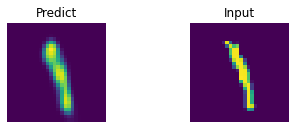

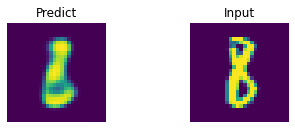

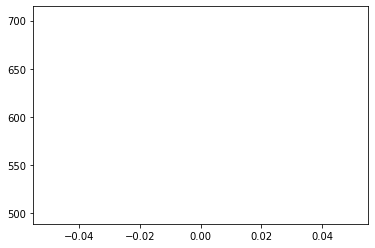

2 of 5
2 / 5 - loss: 490.58299352213544


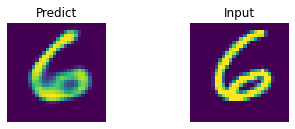

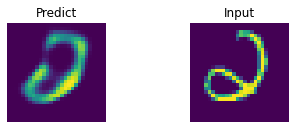

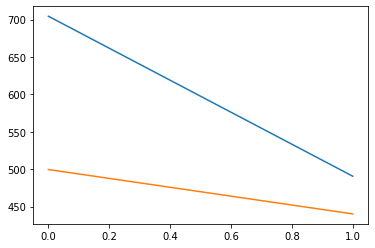

3 of 5
3 / 5 - loss: 452.2429701171875


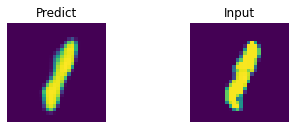

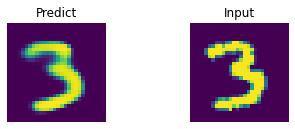

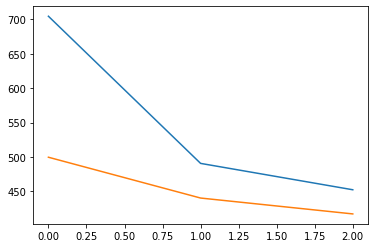

4 of 5
4 / 5 - loss: 430.29431617838543


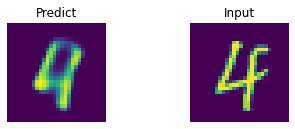

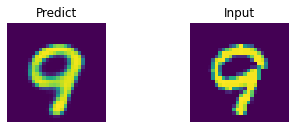

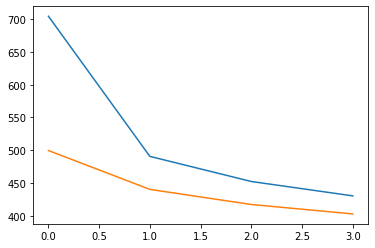

5 of 5
5 / 5 - loss: 416.2222618001302


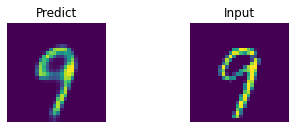

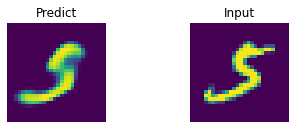

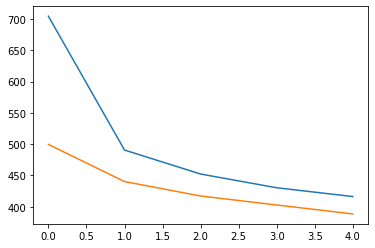

In [ ]:
history_AE = train(autoencoder_VAE, criterion, optimizer, train_loader, test_loader, epochs=5)

Encode and decode pics

In [ ]:
images_VAE = train_dataset.data[:,None,:,:].numpy()
def show_images_VAE(amount_img, model, images):
    batch = torch.tensor(images[0:amount_img]).type(torch.float32)
    model.eval()
    _, _, pred = model(batch.to(device))
    with torch.no_grad():
        for i in range(0, len(batch)): 
            plt.subplot(2, 2, 1)
            plt.imshow(np.rollaxis(pred[i].cpu().numpy(), 0, 3))
            plt.title('Predict')
            plt.axis('off')

            plt.subplot(2, 2, 2)
            plt.imshow(np.rollaxis(batch[i].cpu().numpy(), 0, 3))
            plt.title('Input')
            plt.axis('off')
            plt.show()  

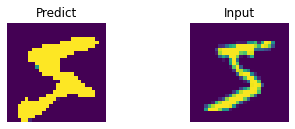

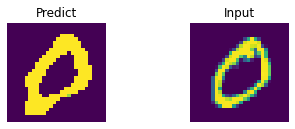

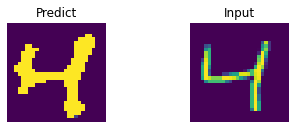

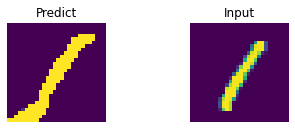

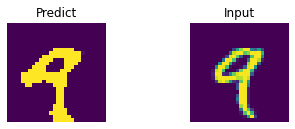

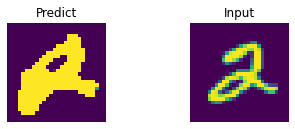

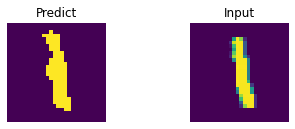

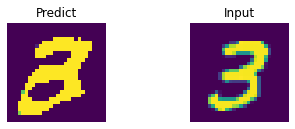

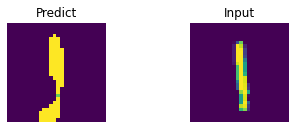

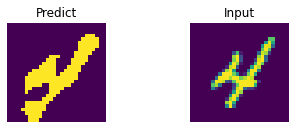

In [ ]:
show_images_VAE(10, autoencoder_VAE, images_VAE)

Generate new pics

(10, 16)


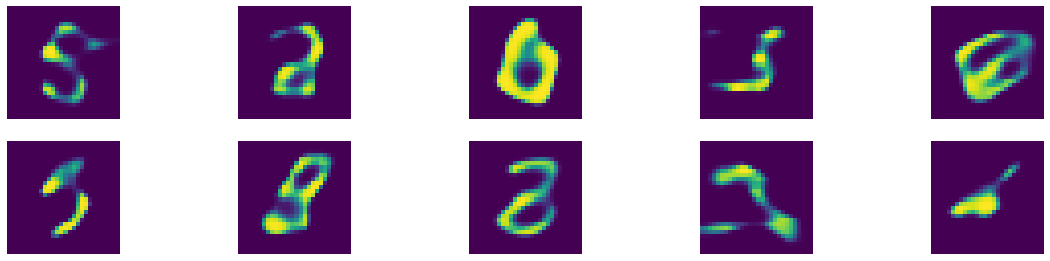

In [ ]:
z = np.array([np.random.normal(0, 1, 16) for i in range(10)])
print(z.shape)
output = autoencoder_VAE.decode(torch.Tensor(z).to(device))
output = output.detach()
fig = plt.figure(figsize=(20,12))
for idx in range(len(output)):
    fig.add_subplot(5, 5, idx+1)
    pic = np.rollaxis(output[idx].cpu().numpy(), 0, 3)
    plt.imshow(pic)
    #print(pic.shape)
    plt.axis('off')

Good results!

## Latent Representation

In [ ]:
from sklearn.manifold import TSNE

Test dataset representation

In [ ]:
data_tsne = test_dataset.data.numpy().reshape((-1,784))
targets = test_dataset.targets
tsne = TSNE(2).fit_transform(data_tsne)

In [ ]:
digits = [int(d.split(' ')[0]) for d in train_dataset.classes]
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'navy', 'purple', 'pink', 'gray', 'black']

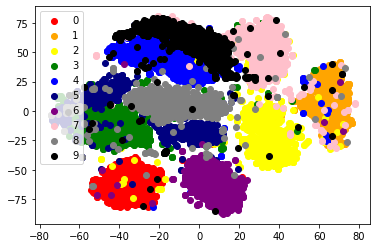

In [ ]:
for d, col in zip(digits, colors) :
    plt.scatter(tsne[targets == d, 0], tsne[targets == d, 1], c=col, label=d)
    plt.legend()

Test dataset VAE

In [ ]:
def pred_images_VAE(amount_img, model, images):
    batch = torch.tensor(images[0:amount_img]).type(torch.float32)/255
    model.eval()
    mu, logsigma, pred = model(batch.to(device))
    return mu, logsigma, pred 

In [ ]:
images_VAE_lc = test_dataset.data[:,None,:,:].numpy()
mu_VAE, logsigma_VAE, pred_test_VAE = pred_images_VAE(len(images_VAE_lc), autoencoder_VAE, images_VAE_lc)

In [ ]:
eps = torch.randn_like(logsigma_VAE)
samples = mu_VAE + torch.exp(logsigma_VAE) * eps

In [ ]:
pred_test_VAE = samples.detach().cpu().numpy()

In [ ]:
tsne_VAE = TSNE(2).fit_transform(pred_test_VAE)

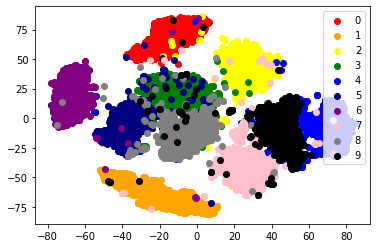

In [ ]:
for d, col in zip(digits, colors) :
    plt.scatter(tsne_VAE[targets == d, 0], tsne_VAE[targets == d, 1], c=col, label=d)
    plt.legend()

## Conditional VAE 


### Build model


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



In [ ]:
dim = 16

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=256),  #784 --> 256
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=dim*2),  #256 --> 16
            nn.ReLU(),
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=16+10, out_features=256),   #18 --> 256
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=784),  #256 --> 784
            nn.Sigmoid()
        )
        
    def encode(self, x, class_num):
        class_num = class_num.type(torch.int64)
        class_num = nn.functional.one_hot(class_num, num_classes=10)
        x = self.encoder(x)
        mu, logsigma = torch.tensor_split(x, 2, dim=1)  
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            sigma = torch.exp(logsigma)
            eps = torch.randn_like(sigma)
            sample = mu + (eps * sigma)
            return sample
        else:
            return mu
    
    def decode(self, z, class_num):
        x = torch.cat((z, class_num), dim=-1)
        reconstruction = self.decoder(x)
        return reconstruction

    def forward(self, x):
        class_num = x[:,-1]   

        x = x[:,:-1]
        mu, logsigma, class_num = self.encode(x, class_num) 
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(sample, class_num)
        return mu, logsigma, reconstruction

In [ ]:
model_CVAE = CVAE()

In [ ]:
summary(model_CVAE, [785])

torch.Size([2, 10])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32]                  --
|    └─Linear: 2-1                       [-1, 256]                 200,960
|    └─ReLU: 2-2                         [-1, 256]                 --
|    └─Dropout: 2-3                      [-1, 256]                 --
|    └─Linear: 2-4                       [-1, 32]                  8,224
|    └─ReLU: 2-5                         [-1, 32]                  --
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 256]                 6,912
|    └─ReLU: 2-7                         [-1, 256]                 --
|    └─Dropout: 2-8                      [-1, 256]                 --
|    └─Linear: 2-9                       [-1, 784]                 201,488
|    └─Sigmoid: 2-10                     [-1, 784]                 --
Total params: 417,584
Trainable params: 417,584
N

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32]                  --
|    └─Linear: 2-1                       [-1, 256]                 200,960
|    └─ReLU: 2-2                         [-1, 256]                 --
|    └─Dropout: 2-3                      [-1, 256]                 --
|    └─Linear: 2-4                       [-1, 32]                  8,224
|    └─ReLU: 2-5                         [-1, 32]                  --
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 256]                 6,912
|    └─ReLU: 2-7                         [-1, 256]                 --
|    └─Dropout: 2-8                      [-1, 256]                 --
|    └─Linear: 2-9                       [-1, 784]                 201,488
|    └─Sigmoid: 2-10                     [-1, 784]                 --
Total params: 417,584
Trainable params: 417,584
Non-trainable params:

In [ ]:
criterion = loss_vae

autoencoder_CVAE = CVAE().to(device)

optimizer = torch.optim.Adam(autoencoder_CVAE.parameters())

In [ ]:
def train(AE_model, loss, optim, dataset_train, dataset_test, bs=64, epochs=10):
    history = {
      'loss': {
          'train': [],
          'val': []
          }
      }  
    data_train = torch.cat((dataset_train.data.view(-1,784)/255, dataset_train.targets.view(-1,1)), dim=-1)
    data_test = torch.cat((dataset_test.data.view(-1,784)/255, dataset_test.targets.view(-1,1)), dim=-1)
    train_loader = torch.utils.data.DataLoader(dataset=data_train, batch_size=bs, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=data_test, batch_size=bs, shuffle=False)
    
    for epoch in range(epochs):
      #clear_output(wait=True)
        print(f'{epoch+1} of {epochs}')
        train_loss = []
        avg_loss = 0
        AE_model.train()
        for X_batch_in in train_loader:  
            
            X_batch_in = (X_batch_in).type(torch.float32).to(device)
            optim.zero_grad()
            mu, logsigma, X_pred = AE_model(X_batch_in)
            _loss = loss(X_batch_in[:,:-1], mu, logsigma, X_pred)
            _loss.mean().backward()
            optim.step()            
            train_loss.append(_loss.mean().item())
        history['loss']['train'].append(sum(train_loss) / len(train_loss))

        AE_model.eval()
        val_loss = []
        pic_examples = []
        with torch.no_grad():           
            for X_batch_val_in in test_loader:
                proba_img = np.round(np.random.randint(0, 6)/10 + 10e-8)
                X_batch_val_in = (X_batch_val_in).type(torch.float32).to(device)
                mu, logsigma, X_val_pred = AE_model(X_batch_val_in)
                _loss = loss(X_batch_val_in[:,:-1], mu, logsigma, X_val_pred)
                
                val_loss.append(_loss.mean().item())
                if proba_img:
                    k = np.random.randint(0, len(X_batch_val_in))
                    pic_examples.append((X_val_pred[k].cpu().numpy(), X_batch_val_in[:,:-1][k].cpu().numpy()))
        
            print(f'{epoch+1} / {epochs} - loss: {sum(train_loss) / len(train_loss)}')
            history['loss']['val'].append(sum(val_loss) / len(val_loss))     
      
            for i in range(1,3): #можно выводить все изображения pic_examples, для демонстрации вывод 2х изображений
                #print(pic_examples[i][0].shape)
                plt.subplot(2, 2, 1)
                plt.imshow(pic_examples[i][0].reshape(28,28))
                plt.title('Predict')
                plt.axis('off')

                plt.subplot(2, 2, 2)
                plt.imshow(pic_examples[i][1].reshape(28,28))
                plt.title('Input')
                plt.axis('off')
                plt.show()  
            plt.plot(history['loss']['train'])
            plt.plot(history['loss']['val'])
            plt.show()
             
    return history

1 of 10
1 / 10 - loss: 2579.2209408888175


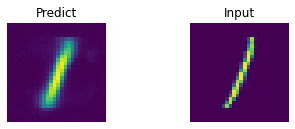

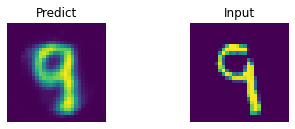

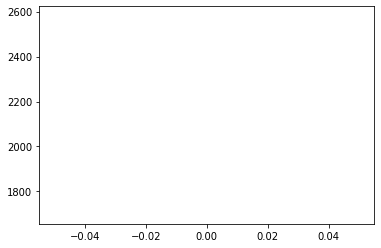

2 of 10
2 / 10 - loss: 1962.1708348646348


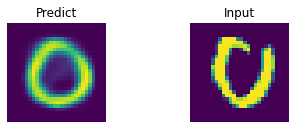

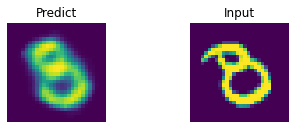

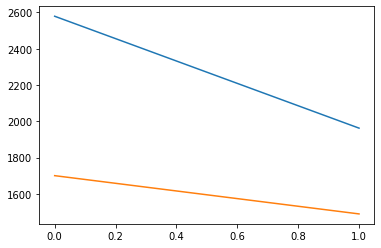

3 of 10
3 / 10 - loss: 1838.0939252320638


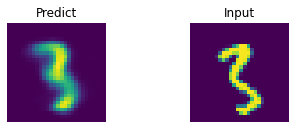

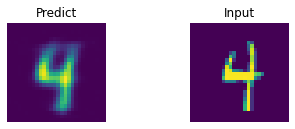

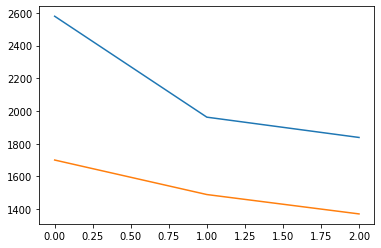

4 of 10
4 / 10 - loss: 1775.8271963286247


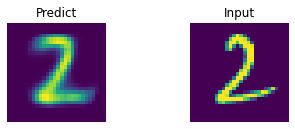

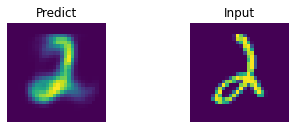

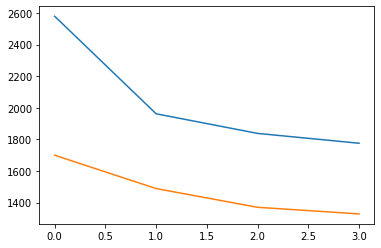

5 of 10
5 / 10 - loss: 1739.1160562023172


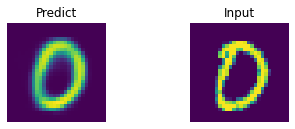

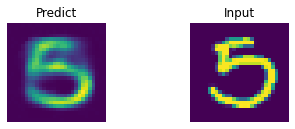

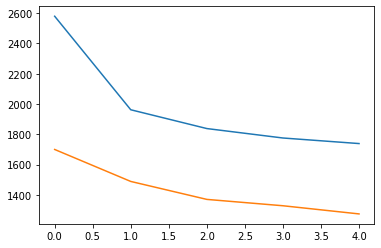

6 of 10
6 / 10 - loss: 1716.6608670037438


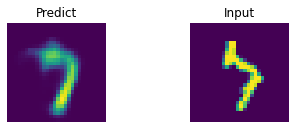

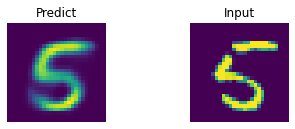

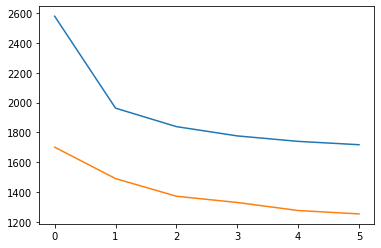

7 of 10
7 / 10 - loss: 1697.3178460420067


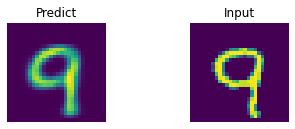

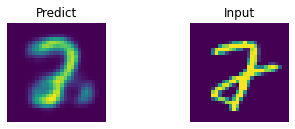

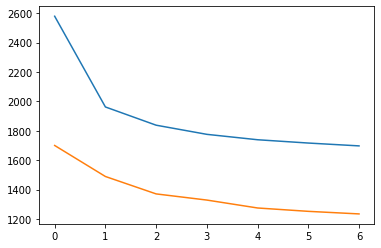

8 of 10
8 / 10 - loss: 1682.8153229735808


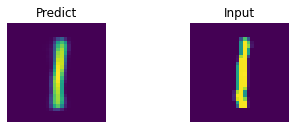

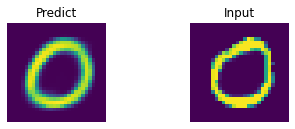

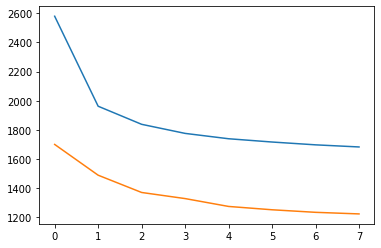

9 of 10
9 / 10 - loss: 1671.8552882473098


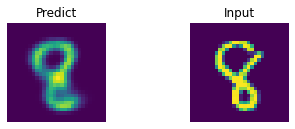

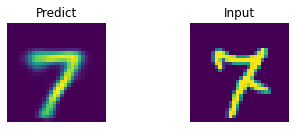

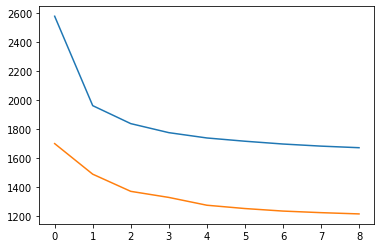

10 of 10
10 / 10 - loss: 1661.649894340206


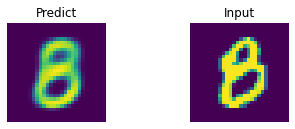

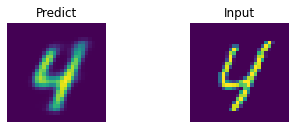

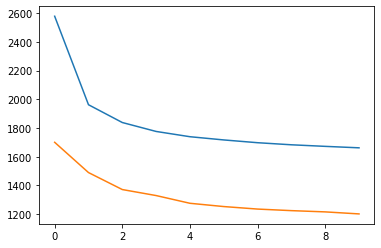

In [ ]:
history_CVAE = train(autoencoder_CVAE, criterion, optimizer, train_dataset, test_dataset)

### Sampling


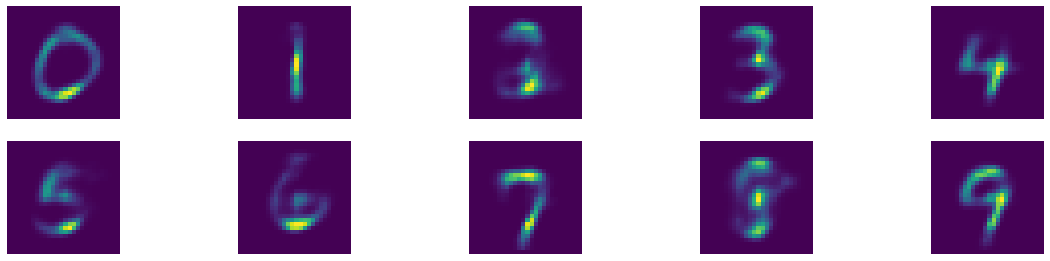

In [ ]:
targets = [i for i in range(10)]
targets = nn.functional.one_hot(torch.Tensor(targets).type(torch.int64))
z = np.random.normal(0, 1, 16)
pics = []
fig = plt.figure(figsize=(20,12))
for digit in targets:
    output = autoencoder_CVAE.decode(torch.Tensor(z).to(device), digit.to(device))
    output = output.detach()
    pic = output.cpu().numpy().reshape((28,28))
    pics.append(pic)

for idx in range(len(pics)):
    fig.add_subplot(5, 5, idx+1)
    pic = pics[idx]
    plt.imshow(pic)
    plt.axis('off')

Good result.

### Latent Representations CVAE

In [ ]:
def pred_images_CVAE(amount_img, model, images):
    batch = torch.tensor(images[0:amount_img]).type(torch.float32)/255
    model.eval()
    mu, logsigma, pred = model(batch.to(device))
    return mu, logsigma, pred 

In [ ]:
test_dataset.targets.numpy().shape

(10000,)

In [ ]:
images_CVAE_lc = np.concatenate((test_dataset.data.numpy().reshape(-1, 784), test_dataset.targets.numpy().reshape(-1, 1)),axis=1)

In [ ]:
mu_CVAE, logsigma_CVAE, pred_test_CVAE = pred_images_VAE(len(images_CVAE_lc), autoencoder_CVAE, images_CVAE_lc)

In [ ]:
eps = torch.randn_like(logsigma_CVAE)
samples = mu_CVAE + torch.exp(logsigma_CVAE) * eps
pred_test_CVAE = mu_CVAE.detach().cpu().numpy()

In [ ]:
tsne_CVAE = TSNE(2).fit_transform(pred_test_CVAE)

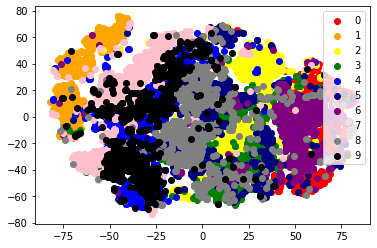

In [ ]:
for d, col in zip(digits, colors) :
    plt.scatter(tsne_CVAE[targets == d, 0], tsne_CVAE[targets == d, 1], c=col, label=d)
    plt.legend()